In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

import helper
import os
import pickle
import glob
import re

In [ ]:
train_path = "/content/gdrive/My Drive/SpongeBob_Transcripts/train/" 
valid_path = "/content/gdrive/My Drive/SpongeBob_Transcripts/valid/" 
test_path = "/content/gdrive/My Drive/SpongeBob_Transcripts/test/"

train_path_small = "/content/gdrive/My Drive/SpongeBob_Transcripts_small/train/"

# Pre-processing Data

Pre-process the data by using the helper functions below.
The helper function helps convert the text files to sequences of words by creating a vocabulary of unique words. We also get mappings of vocabulary words to indexes and vice versa.

In [ ]:
def get_clean_text(file_path):
  """
  Read the file and convert the text into a list of words.
  """
  text = ""
  for file in glob.glob(file_path+"*.txt"):
      f = open(file)
      f.readline() # remove blank line at the top of the script
      text += f.read()
      f.close()
  text = text.split('\n')
  clean_text=[]
  for sentence in text:
    temp = [word.lower() for word in re.findall(r'\w+|[^\s\w]', sentence)]
    temp.append("\n")
    clean_text.append(temp)
  return clean_text

def get_vocab(final_text):
  """
  Create a vocabulary of unique words from the provided list of words.
  """
  vocab = set([word for sentence in final_text for word in sentence])
  return vocab

def get_vocab_itos(v):
  """
  Create a dictionary or mapping of vocabulary words to integers.
  """
  return dict(enumerate(v))

def get_vocab_stoi(vocab_itos):
  """
  Create a dictionary or mapping of integers to  vocabulary words.
  """
  vocab_stoi = {word:index for index, word in vocab_itos.items()}
  return vocab_stoi

## Dataloader

In [ ]:
def get_dataloader(text, seq_length, batch_size):
  """
  Create a dataloader from the given list of words, 
  sequence length and batch size. Returns a Pytorch Tensor with 
  input and output labels. The shape of the input is batch sizexsequence length
  and the shape of the output is the batch size.
  """
  feature, target = [],[]
  target_len = (len(text) // batch_size) * batch_size - seq_length
  
  for i in range(target_len):
      feature.append(text[i: i + seq_length])
      target.append(text[i + seq_length])
  
  target_tensors = torch.from_numpy(np.array(target))
  feature_tensors = torch.from_numpy(np.array(feature))
  
  data = TensorDataset(feature_tensors, target_tensors)
  
  data_loader = torch.utils.data.DataLoader(data, batch_size = batch_size, shuffle = True)
  
  return data_loader

# RNN Model Architecture

Create a RNN Model with 4 layers in the following order:
1. Embedding layer
2. LSTM layer
3. Dropout layer
4. Final fully connected linear layer

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.3):
      super(RNN,self).__init__()
      self.n_layers  = n_layers
      self.output_size = output_size
      self.hidden_dim = hidden_dim
      self.vocab_size = vocab_size
      self.dropout = nn.Dropout(dropout)
      self.embedding_dim = embedding_dim
      
      # Model Layers
      self.embedding = nn.Embedding(vocab_size,
                                    embedding_dim)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first = True)
      self.fc = nn.Linear(hidden_dim, 
                          output_size)
        
    def forward(self, data):
      vs = self.embedding(data)
      output, (h_n, c_n) = self.lstm(vs)
      m1 = self.dropout(h_n[-1])
      z = self.fc(m1) 
      return z

# Accuracy

In [ ]:
train_on_gpu = torch.cuda.is_available()

In [ ]:
def get_accuracy(model, data_loader):
  """
  Returns the accuracy of the model of the given model
  and the dataloader.
  """
  model.eval()
  correct = 0
  total = 0
  for inputs, labels in data_loader:
      if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
        model.to(torch.device("cuda"))
      output = model.forward(inputs)
      pred = output.max(1, keepdim=True)[1].reshape(output.shape[0])
      correct += pred.eq(labels).sum().item()
      total += inputs.shape[0]
      
  return correct / total

# Train Model

We use Cross Entropy Loss and Adam's optimizer.
This method uses Pytorch's forward and backward method to perform gradient descent and train the model. It plots the loss, training accuracy and validation accuracy after the model has completed training.

In [ ]:
def train(model, train_loader, val_loader, batch_size, num_epochs, lr, weight_decay):
  """
  Train the model.
  """

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  num_iter, num_iters_sub, all_losses, train_acc, valid_acc = [], [], [], [], []
  n = 0

  for epoch in range(num_epochs):
    for inputs, labels in iter(train_loader):
      if train_on_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
        model.to(torch.device("cuda"))

      if labels.size()[0] > batch_size:
        break
      
      model.train() # annote model for training

      # forward/backward prop
      output = model.forward(inputs)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      num_iter.append(n)
      all_losses.append(float(loss) / batch_size)

      if n % 50 == 0:
        num_iters_sub.append(n)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, val_loader))


      # increment n 
      n+=1


    epoch_train_acc = get_accuracy(model, train_loader)
    epoch_val_acc = get_accuracy(model, val_loader)
    print("epoch %d. [Val Acc %.0f%%] [Train Acc %.0f%%] [Loss %f]" % ((epoch+1), epoch_val_acc * 100, epoch_train_acc * 100, loss))
      
  # print final accuracy
  final_train_acc = get_accuracy(model, train_loader)
  final_val_acc = get_accuracy(model, val_loader)
  print("Final Accuracy: [Val Acc %.0f%%] [Train Acc %.0f%%]" % (final_val_acc * 100, final_train_acc * 100))
  
  # plot learning curve
  plt.title("Learning Curve: Loss per Iteration")
  plt.plot(num_iter, all_losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()
    
  plt.title("Learning Curve: Accuracy per Iteration")
  plt.plot(num_iters_sub, train_acc, label="Train")
  plt.plot(num_iters_sub, valid_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()

# Training the Model and Hyperparameters

In [ ]:
train_clean_text = get_clean_text(train_path)
valid_clean_text = get_clean_text(valid_path)

train_vocab = get_vocab(train_clean_text)
valid_vocab = get_vocab(valid_clean_text)
final_vocab = train_vocab | valid_vocab

final_vocab_itos = get_vocab_itos(final_vocab)
final_vocab_stoi = get_vocab_stoi(final_vocab_itos)

int_train_text = [final_vocab_stoi[word] for sentence in train_clean_text for word in sentence]
int_valid_text = [final_vocab_stoi[word] for sentence in valid_clean_text for word in sentence]

batch = 800
train_data_loader = get_dataloader(int_train_text, seq_length=8, batch_size=batch)
valid_data_loader = get_dataloader(int_valid_text, seq_length=8, batch_size=batch)


epoch 1. [Val Acc 4%] [Train Acc 4%] [Loss 6.087188]
epoch 2. [Val Acc 17%] [Train Acc 17%] [Loss 5.478667]
epoch 3. [Val Acc 25%] [Train Acc 26%] [Loss 4.495725]
epoch 4. [Val Acc 26%] [Train Acc 28%] [Loss 4.265636]
epoch 5. [Val Acc 27%] [Train Acc 30%] [Loss 3.808640]
epoch 6. [Val Acc 28%] [Train Acc 31%] [Loss 3.891315]
epoch 7. [Val Acc 28%] [Train Acc 31%] [Loss 3.867038]
epoch 8. [Val Acc 28%] [Train Acc 32%] [Loss 3.719770]
epoch 9. [Val Acc 28%] [Train Acc 33%] [Loss 3.640214]
epoch 10. [Val Acc 28%] [Train Acc 33%] [Loss 3.673307]
epoch 11. [Val Acc 29%] [Train Acc 34%] [Loss 3.548865]
epoch 12. [Val Acc 29%] [Train Acc 34%] [Loss 3.518346]
epoch 13. [Val Acc 28%] [Train Acc 35%] [Loss 3.617831]
epoch 14. [Val Acc 29%] [Train Acc 35%] [Loss 3.686229]
epoch 15. [Val Acc 29%] [Train Acc 36%] [Loss 3.635633]
epoch 16. [Val Acc 28%] [Train Acc 36%] [Loss 3.353889]
epoch 17. [Val Acc 29%] [Train Acc 37%] [Loss 3.338577]
epoch 18. [Val Acc 28%] [Train Acc 37%] [Loss 3.241494]
epo

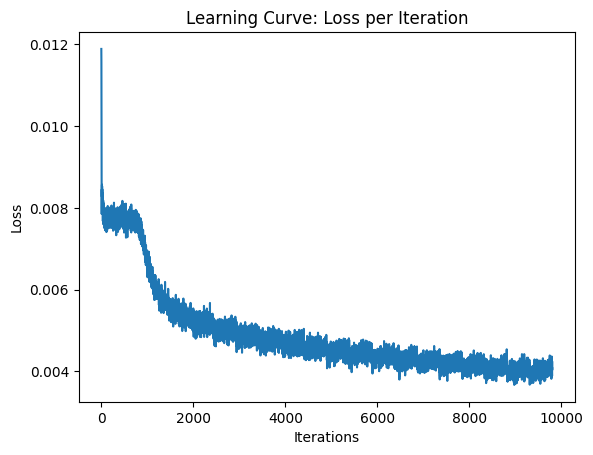

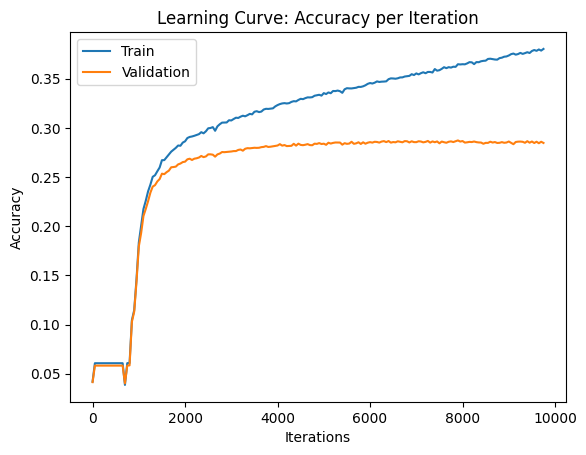

In [ ]:
# The final RNN model with our best set of hyperparameters.

best_rnn = RNN(len(final_vocab), len(final_vocab), embedding_dim=100, hidden_dim=128, n_layers=2)
train(best_rnn, train_data_loader, valid_data_loader, batch_size=batch, num_epochs=20,lr=0.006, weight_decay=0.0)

epoch 1. [Val Acc 25%] [Train Acc 25%] [Loss 4.328292]
epoch 2. [Val Acc 27%] [Train Acc 28%] [Loss 4.493526]
epoch 3. [Val Acc 27%] [Train Acc 28%] [Loss 4.315795]
epoch 4. [Val Acc 27%] [Train Acc 29%] [Loss 4.377937]
epoch 5. [Val Acc 27%] [Train Acc 29%] [Loss 4.181738]
epoch 6. [Val Acc 28%] [Train Acc 29%] [Loss 4.402631]
epoch 7. [Val Acc 28%] [Train Acc 29%] [Loss 4.207443]
epoch 8. [Val Acc 28%] [Train Acc 30%] [Loss 4.335153]
epoch 9. [Val Acc 28%] [Train Acc 30%] [Loss 4.296126]
epoch 10. [Val Acc 28%] [Train Acc 30%] [Loss 4.111723]
epoch 11. [Val Acc 28%] [Train Acc 30%] [Loss 4.314598]
epoch 12. [Val Acc 28%] [Train Acc 30%] [Loss 4.122876]
epoch 13. [Val Acc 28%] [Train Acc 30%] [Loss 4.201322]
epoch 14. [Val Acc 28%] [Train Acc 30%] [Loss 4.248181]
epoch 15. [Val Acc 28%] [Train Acc 30%] [Loss 4.152659]
epoch 16. [Val Acc 28%] [Train Acc 30%] [Loss 4.218546]
epoch 17. [Val Acc 28%] [Train Acc 30%] [Loss 4.188478]
epoch 18. [Val Acc 28%] [Train Acc 30%] [Loss 4.344800]
e

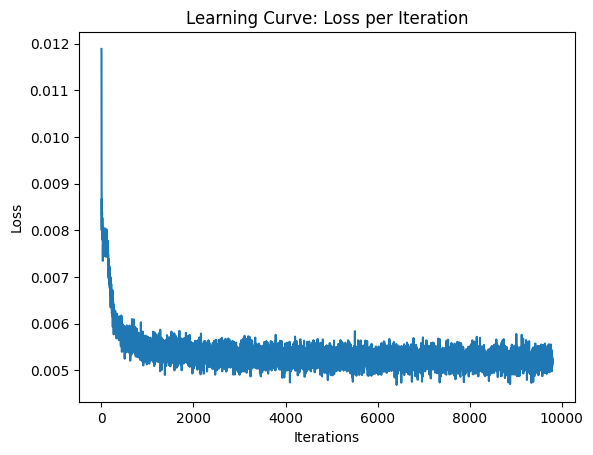

In [ ]:
# An example of a model with a noisy loss curve and poor training and validation accuracy with
# this set of hyperparameters. In this example we only plot 
# the loss curve at the end as this model is run to demonstrate a bad set of hyperparameters.

rnn1 = RNN(len(final_vocab), len(final_vocab), embedding_dim=100, hidden_dim=128, n_layers=2)
train(rnn1, train_data_loader, valid_data_loader, batch_size=batch, num_epochs=20,lr=0.01, weight_decay=0.0001)

epoch 1. [Val Acc 6%] [Train Acc 6%] [Loss 5.874750]
epoch 2. [Val Acc 12%] [Train Acc 13%] [Loss 5.508639]
epoch 3. [Val Acc 19%] [Train Acc 19%] [Loss 5.334950]
epoch 4. [Val Acc 21%] [Train Acc 21%] [Loss 5.052295]
epoch 5. [Val Acc 21%] [Train Acc 22%] [Loss 4.693438]
epoch 6. [Val Acc 22%] [Train Acc 23%] [Loss 4.724463]
epoch 7. [Val Acc 23%] [Train Acc 24%] [Loss 4.669652]
epoch 8. [Val Acc 24%] [Train Acc 24%] [Loss 4.645937]
epoch 9. [Val Acc 24%] [Train Acc 25%] [Loss 4.529886]
epoch 10. [Val Acc 24%] [Train Acc 25%] [Loss 4.525114]
epoch 11. [Val Acc 25%] [Train Acc 26%] [Loss 4.259366]
epoch 12. [Val Acc 25%] [Train Acc 26%] [Loss 4.395080]
epoch 13. [Val Acc 25%] [Train Acc 27%] [Loss 4.220595]
epoch 14. [Val Acc 26%] [Train Acc 27%] [Loss 4.117673]
epoch 15. [Val Acc 26%] [Train Acc 27%] [Loss 4.087262]
epoch 16. [Val Acc 26%] [Train Acc 28%] [Loss 4.443240]
epoch 17. [Val Acc 26%] [Train Acc 28%] [Loss 4.142117]
epoch 18. [Val Acc 26%] [Train Acc 28%] [Loss 4.186444]
epo

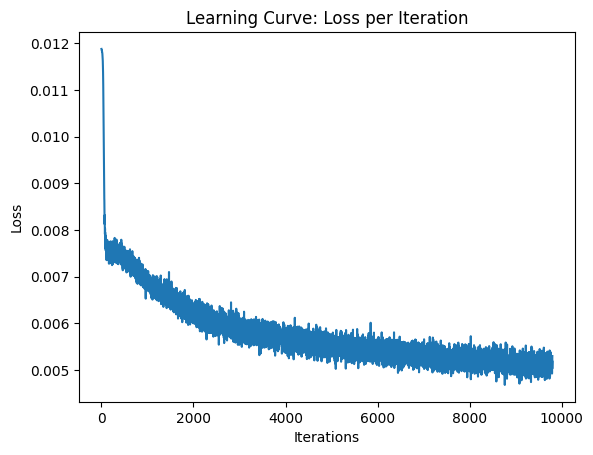

In [ ]:
# An example of a model with a noisy loss curve, steep initial decline and poor training
# and validation accuracy with this set of hyperparameters. In this example we only plot 
# the loss curve at the end as this model is run to demonstrate a bad set of hyperparameters. 

rnn2 = RNN(len(final_vocab), len(final_vocab), embedding_dim=100, hidden_dim=128, n_layers=2)
train(rnn2, train_data_loader, valid_data_loader, batch_size=batch, num_epochs=20,lr=0.00025, weight_decay=0.0)

epoch 1. [Val Acc 21%] [Train Acc 22%] [Loss 5.029705]
epoch 2. [Val Acc 26%] [Train Acc 28%] [Loss 4.500968]
epoch 3. [Val Acc 28%] [Train Acc 30%] [Loss 4.130002]
epoch 4. [Val Acc 28%] [Train Acc 32%] [Loss 3.802616]
epoch 5. [Val Acc 29%] [Train Acc 33%] [Loss 3.887073]
epoch 6. [Val Acc 29%] [Train Acc 34%] [Loss 3.742010]
epoch 7. [Val Acc 29%] [Train Acc 35%] [Loss 3.640457]
epoch 8. [Val Acc 29%] [Train Acc 36%] [Loss 3.548805]
epoch 9. [Val Acc 29%] [Train Acc 37%] [Loss 3.406845]
epoch 10. [Val Acc 29%] [Train Acc 38%] [Loss 3.563597]
epoch 11. [Val Acc 29%] [Train Acc 39%] [Loss 3.306906]
epoch 12. [Val Acc 29%] [Train Acc 40%] [Loss 3.239260]
epoch 13. [Val Acc 29%] [Train Acc 40%] [Loss 3.117677]
epoch 14. [Val Acc 29%] [Train Acc 41%] [Loss 3.161618]
epoch 15. [Val Acc 29%] [Train Acc 42%] [Loss 3.146683]
epoch 16. [Val Acc 29%] [Train Acc 43%] [Loss 2.982313]
epoch 17. [Val Acc 29%] [Train Acc 44%] [Loss 3.090552]
epoch 18. [Val Acc 29%] [Train Acc 44%] [Loss 2.949390]
e

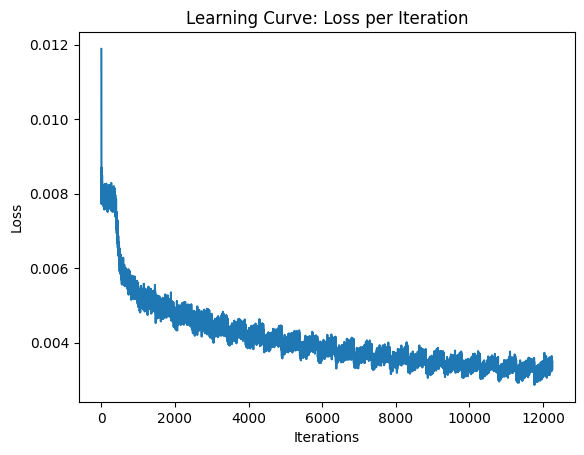

In [ ]:
# An example of a model with a noisy loss curve, and high training
# and low validation accuracy with this set of hyperparameters. This model starts 
# overfitting after epochs 10-12. In this example we only plot 
# the loss curve at the end as this model is run to demonstrate a bad set of hyperparameters. 

rnn3 = RNN(len(final_vocab), len(final_vocab), embedding_dim=250, hidden_dim=250, n_layers=2)
train(rnn3, train_data_loader, valid_data_loader, batch_size=batch, num_epochs=25,lr=0.006, weight_decay=0.0)

# Overfitting to a Small Dataset

epoch 1. [Val Acc 14%] [Train Acc 14%] [Loss 4.890825]
epoch 2. [Val Acc 23%] [Train Acc 23%] [Loss 4.250897]
epoch 3. [Val Acc 30%] [Train Acc 30%] [Loss 3.733367]
epoch 4. [Val Acc 36%] [Train Acc 36%] [Loss 3.506440]
epoch 5. [Val Acc 47%] [Train Acc 47%] [Loss 3.213093]
epoch 6. [Val Acc 55%] [Train Acc 55%] [Loss 2.711121]
epoch 7. [Val Acc 66%] [Train Acc 66%] [Loss 2.313717]
epoch 8. [Val Acc 75%] [Train Acc 75%] [Loss 1.967124]
epoch 9. [Val Acc 82%] [Train Acc 82%] [Loss 1.789655]
epoch 10. [Val Acc 88%] [Train Acc 88%] [Loss 1.814085]
epoch 11. [Val Acc 91%] [Train Acc 91%] [Loss 0.952095]
epoch 12. [Val Acc 94%] [Train Acc 94%] [Loss 0.945499]
epoch 13. [Val Acc 95%] [Train Acc 95%] [Loss 0.651170]
epoch 14. [Val Acc 95%] [Train Acc 95%] [Loss 0.500778]
epoch 15. [Val Acc 96%] [Train Acc 96%] [Loss 0.594666]
epoch 16. [Val Acc 97%] [Train Acc 97%] [Loss 0.398288]
epoch 17. [Val Acc 97%] [Train Acc 97%] [Loss 0.661160]
epoch 18. [Val Acc 98%] [Train Acc 98%] [Loss 0.268983]
e

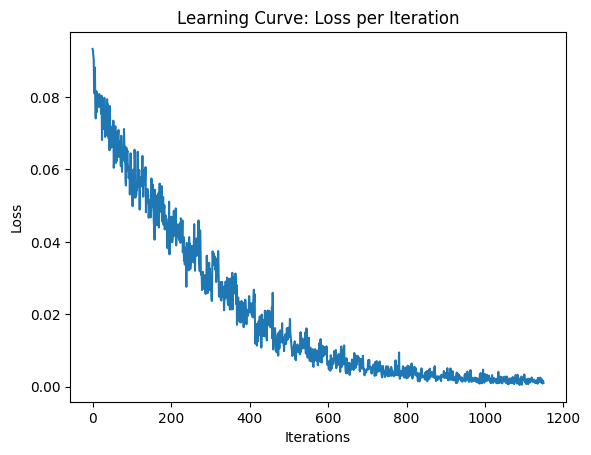

In [ ]:
# We train our model on a very small dataset (just one file). In this example we only plot 
# the loss curve at the end as this model is run to demonstrate overfitting on a small
# dataset.

train_small_clean_text = get_clean_text(train_path_small)

train_small_vocab = get_vocab(train_small_clean_text)

train_small_vocab_itos = get_vocab_itos(train_small_vocab)
train_small_vocab_stoi = get_vocab_stoi(train_small_vocab_itos)

int_train_small_text = [train_small_vocab_stoi[word] for sentence in train_small_clean_text for word in sentence]

batch = 70
train_data_small_loader = get_dataloader(int_train_small_text, seq_length=8, batch_size=batch)

rnn_small = RNN(len(train_small_vocab), len(train_small_vocab), embedding_dim=100, hidden_dim=128, n_layers=2)
train(rnn_small, train_data_small_loader, train_data_small_loader, batch_size=batch, num_epochs=25,lr=0.0065, weight_decay=0.0)

# Generate Script

In [ ]:
import torch.nn.functional as F

sequence_length = 8

def generate(rnn, startword, int_to_vocab, pad_value, predict_len=100):
  """
  Generate a script using the trained model, a word to start the script with, our
  int_to_vocab mapping, a padding value and the maximum lenght of the script to be generated.
  """
  rnn.eval()
  # Create a sequence, with the start word
  current_seq = np.full((1, sequence_length), pad_value)
  current_seq[-1][-1] = startword
  predicted = [int_to_vocab[startword]]
 
  for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)

        output = rnn(current_seq) # Achieve an output from model

        # Probalities of next word
        p = F.softmax(output, dim=1).data
        if(train_on_gpu):
            p = p.cpu()

        # Use topk to sort probalities and get index of next word
        top_k = 5
        p, top_i = p.topk(top_k) # Returns the 5 largest elements of the given input tensor along a given dimension.
        top_i = top_i.numpy().squeeze()

        # Find the most likely next word, using some randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())

        word = int_to_vocab[word_i]
        predicted.append(word)

        current_seq = current_seq.cpu().numpy()
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
  
  # Joining and fixing punctions of predicted generation
  gen_sentences = ' '.join(predicted)
  
  gen_sentences = gen_sentences.replace('\n ', '\n')
  gen_sentences = gen_sentences.replace('( ', '(')
  gen_sentences = gen_sentences.replace(' :', ':')
  gen_sentences = gen_sentences.replace(' \' ', '\'')
  gen_sentences = gen_sentences.replace(' ?', '?')
  gen_sentences = gen_sentences.replace(' . ', '. ')
  gen_sentences = gen_sentences.replace('. ..', '...')
  gen_sentences = gen_sentences.replace('.. .', '...')
  gen_sentences = gen_sentences.replace(' ! ', '! ')
  gen_sentences = gen_sentences.replace(' , ', ', ')

  return gen_sentences
    

gen_length = 600  # Input the length of the script
prime_word = 'spongebob' # Starting word for script

generated_script = generate(best_rnn, final_vocab_stoi[prime_word], final_vocab_itos, np.inf, gen_length)
print(generated_script)


spongebob looks patrick. ". 
spongebob: [ screams and runs to the krusty krab. the little clown is still wandering in the process and down ] 
squidward: [ gasps ] what do you know. i've got a krabby patty deluxe! [ laughs ] 
mr. krabs: i'm a genius. 
spongebob: i have a good time, mr. krabs! 
mr. krabs: oh, i've been taught your new dishwasher, you dunce. 
patrick: i don't know what a big snail! 
[ the scene changes to a wide - wire noise, he gets a little calculator ] 
patrick: [ walks over to the krusty krab. the trash robot pulls up the door and he's been in the krusty krab, you are going to have to have to get a good friend. 
squidward: oh, no, no, no. 
patrick: i can't believe. [ spongebob is sleeping and the sea chimps bind inside the krusty krab ] 
squidward: [ laughs ] what? what's your house, you're going to go to work! i've been in a krabby patty. 
spongebob: i'll never find you. 
[ the episode begins in spongebob's house. spongebob walks out of the krusty krab ] 
spongebob: 

Generating Scripts with different Prime Words

In [ ]:
prime_word = 'beaches'
generated_script = generate(best_rnn, final_vocab_stoi[prime_word], final_vocab_itos, np.inf, gen_length)
print(generated_script)

beaches where. 
squidward: [ gasps as he is heard ] 
mr. krabs: [ gasps ] what's that? 
spongebob: no way, patrick, we'll never get the little twerp more, spongebob. 
spongebob: oh, yeah, i'm the most amazing! 
patrick: i can't believe that award was just a little dry! 
[ mr. krabs laughs. ] 
spongebob: hey, squidward! 
[ squidward's house is heard ] 
spongebob: [ walks out from the door ] 
squidward: [ chuckles ] no, no, wait a minute. [ he walks up to the kitchen and sees a piece of the box ] 
spongebob: oh, i think i've had to go back here! [ laughs ] 
mr. krabs: [ gasps ] what's the name? 
[ the trash robot grabs the patty and his body falls in the hole. spongebob and patrick are in his own creation, which is shown ] 
[ the scene changes to the chum bucket. ] 
mr. krabs: [ screams and sees the krusty krab and the scene changes to spongebob, mr. krabs is in a picture of a hole in the kitchen and he sees the krusty krab. the scene changes to spongebob and patrick in his head ] 
squid

In [ ]:
prime_word = 'squidward'
generated_script = generate(best_rnn, final_vocab_stoi[prime_word], final_vocab_itos, np.inf, gen_length)
print(generated_script)

squidward, ha ha ha ha ha ha ha ha ha ha... 
spongebob: oh. i'm a zombie... [ spongebob and squidward are in the background ] 
squidward: [ laughs ] oh, yeah! 
mr. krabs: i'm the worst host - a - yellin. ] 
squidward: [ gets off and falls down and spongebob is shown. he then walks over to a pile of spongebob and his head is shown. ] 
squidward: [ chuckles ] oh, yeah! 
squidward: [ gasps ] i'm not going to go in the krusty krab. ] 
spongebob: [ gasps ] i know, i'm not a little good time, squidward. 
spongebob: oh, you can't do it! [ spongebob screams in a picture of a krabby patty. spongebob laughs ] 
spongebob: oh, oh, i'll have a little bit of the krusty krab: [ gasps ] oh, you'll get a little unscrupulous a long - erer. you've got the secret formula! 
[ spongebob and patrick laugh. ] 
patrick: [ gasps ] 
[ patrick's house rolls into the krusty krab where he is in his house and he's not. ] 
plankton: i'm gonna get it! [ spongebob looks out of the kitchen and the sea chimps are laughin

# Statistics

In [ ]:
def get_text(files, source_path):
  """
  Read the file and convert the text into a list of words.
  """
  text = ""
  for file in files:
      f = open(source_path + file)
      f.readline() # remove blank line at the top of the script
      text += f.read()
      f.close()
  text = text.split('\n')
  clean_text=[]
  for sentence in text:
    temp = [word.lower() for word in re.findall(r'\w+|[^\s\w]', sentence)]
    temp.append("\n")
    clean_text.extend(temp)
  return clean_text

In [ ]:
def episode_clean_text(file):
  """
  Read the file and convert the text into a list of words.
  """
  text = ""
  f = open(train_path + file)
  f.readline() # remove blank line at the top of the script
  text += f.read()
  f.close()
  text = text.split('\n')
  clean_text=[]
  n = 0
  for sentence in text:
    temp = [word.lower() for word in re.findall(r'\w+', sentence)]
    temp.append("\n")
    clean_text.extend(temp)
    n += 1
  return clean_text, n

In [ ]:
train_files = os.listdir(train_path)
valid_files = os.listdir(valid_path)
test_files = os.listdir(test_path)
all_episodes = train_files + valid_files + test_files
num_episodes = len(all_episodes)

# Number of episodes used (and how they were split among training/validation) 
print(f"We used {num_episodes} episodes in total.")
print(f"There are {len(train_files)} episodes in the training set.")
print(f"There are {len(valid_files)} episodes in the validation set.")

# Number of unique words (i.e. vocab size)
print(f"There are {len(final_vocab)} unique words among all episodes.")

# Average number of words in one episode
train_words = get_text(train_files, train_path)
valid_words = get_text(valid_files, valid_path)
total = len(train_words) + len(valid_words)
print(f"There is an average of {total // num_episodes} words per episode.")

# Average number of words per line (taken from one episode)
sentences, sentence_count = episode_clean_text(train_files[0])
print(f"There is an average of {len(sentences) // sentence_count} words per line.")

# Note: Punctuation was taken out of the word counts.

# 10 most common words

We used 200 episodes in total.
There are 120 episodes in the training set.
There are 40 episodes in the validation set.
There are 13456 unique words among all episodes.
There is an average of 2696 words per episode.
There is an average of 16 words per line.
